In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset,random_split
import torchvision.models as models
import torch.nn.functional as F
from PIL import Image
import os
import numpy as np

import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [33]:
class VGG16BinaryClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super(VGG16BinaryClassifier, self).__init__()

        # Load VGG-16 model
        self.vgg16 = models.vgg16(pretrained=pretrained)

        # Freeze convolutional layers (optional)
        for param in self.vgg16.features.parameters():
            param.requires_grad = True  # Set to True if you want to fine-tune

        # Modify the classifier head for binary classification
        self.vgg16.classifier = nn.Sequential(
            nn.Linear(25088, 4096),  # VGG-16's default input size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 512),  # Custom hidden layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # Output 1 logit (for binary classification)
        )

    def forward(self, x):
        return self.vgg16(x)  # No sigmoid, return raw logits
    
def load_model(model_path, device):
    # Instantiate the model
    model = VGG16BinaryClassifier(pretrained=True)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    # print(model)
    return model

# Instantiate the model
vgg_model = VGG16BinaryClassifier(pretrained=True)
print(vgg_model)

VGG16BinaryClassifier(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True

### Load 'best_VGG_model_1' from github

In [34]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model_path = "best_VGG_model_1.pth"
model = load_model(model_path, device)

### Set dataset directory

In [42]:
# Transform (adjust if model trained on grayscale or normalized differently)
transform = transforms.Compose([
    transforms.Resize((1024, 512)),  # keep the original shape
    transforms.ToTensor(),
])

# Get list of first 3 image paths
image_folder = 'dataset/fovea_yes'
image_paths = sorted(os.listdir(image_folder))[:3]  # sort to get consistent order
print(image_paths)

['2002000001_20240311_132300_OD_Carl_Zeiss_Meditec_5000_512x1024x128_ORG_IMG_JPG_056.jpg', '2002000001_20240311_132300_OD_Carl_Zeiss_Meditec_5000_512x1024x128_ORG_IMG_JPG_072.jpg', '2002000002_20240311_132300_OD_Carl_Zeiss_Meditec_5000_512x1024x128_ORG_IMG_JPG_056.jpg']


### Create saliency maps

In [ ]:
saliency_maps = []

for i, filename in enumerate(image_paths):
    img_path = os.path.join(image_folder, filename)
    image = Image.open(img_path).convert('RGB')  # use 'L' if grayscale
    
    # we create an input tensor in order to store the gradients associated with it
    # the idea behind creating a heatmap is basically just finding the gradient
    # of the prediction with respect to each individual pixel
    # towards this end, we must ensure that the gradients are required for 
    # the input tensor, as these gradients will implictly store the heatmap information.
    input_tensor = transform(image).unsqueeze(0)  # shape: [1, 3, 1024, 512]
    input_tensor.requires_grad_()

    output = model(input_tensor)

    ### NOTE: we no longer want round to a pure number. We want to make sure that we don't kill the gradients with round() or int().
    class_score = torch.sigmoid(output)[0, 0]  # or just output[0, 0] if using BCEWithLogitsLoss
    class_score.backward()

    # Saliency = max absolute gradient across channels
    # with just this single line, we can find the saliency, as the 
    # heatmap is implicitly stored in the gradient with respect to the input tensor
    saliency = input_tensor.grad.data.abs().squeeze().detach().numpy()
    saliency = np.max(saliency, axis=0)
    saliency_maps.append((image, saliency))


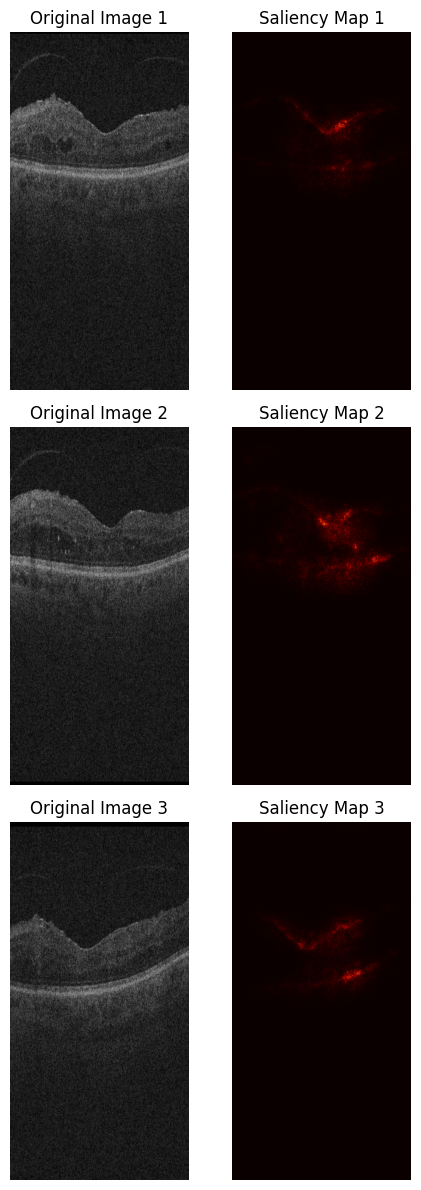

In [70]:
fig, axes = plt.subplots(3, 2, figsize=(5, 12))

for i, (image, saliency) in enumerate(saliency_maps):
    axes[i, 0].imshow(image)
    axes[i, 0].set_title(f"Original Image {i+1}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(saliency, cmap='hot')
    axes[i, 1].set_title(f"Saliency Map {i+1}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


### Create binary masks from saliency maps

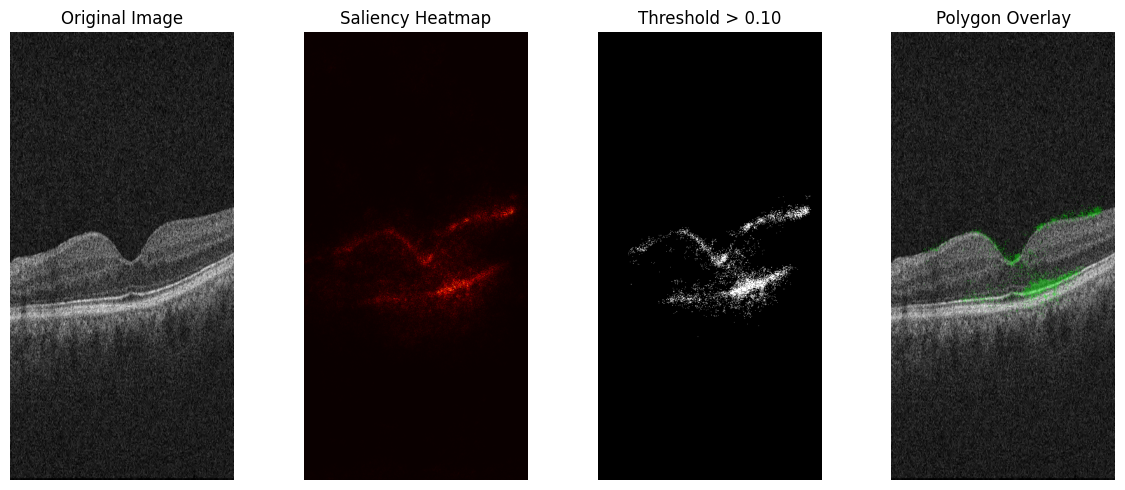

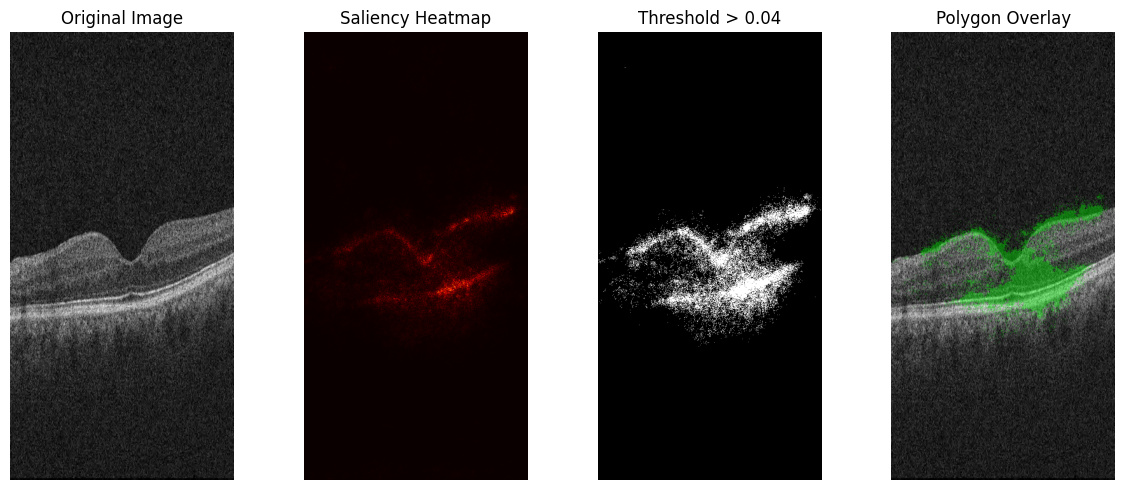

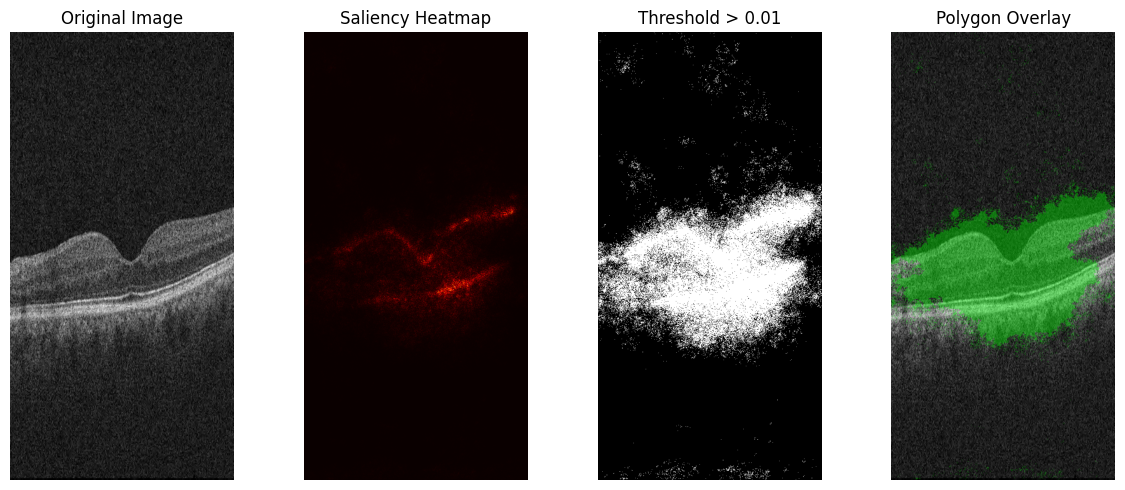

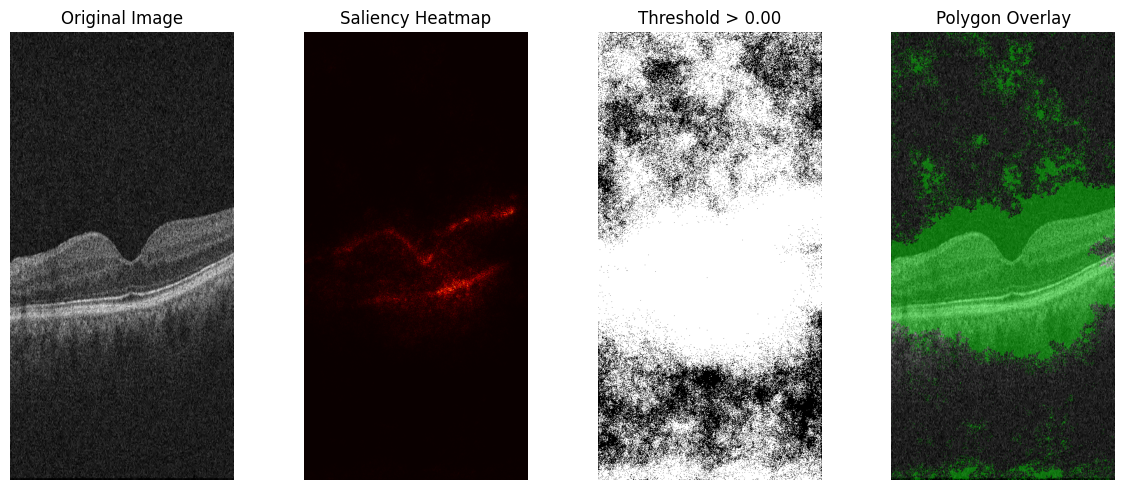

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

def visualize_saliency_polygons(image_pil, saliency, threshold_ratio=0.5, alpha=0.4):
    """
    image_pil: original PIL image
    saliency: numpy array (H, W), raw saliency map
    threshold_ratio: float between 0 and 1 to threshold saliency
    alpha: transparency of the polygon overlay
    """

    # Normalize saliency
    saliency_norm = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
    threshold_val = threshold_ratio * saliency_norm.max()
    binary_mask = saliency_norm > threshold_val

    # Convert to 8-bit
    saliency_8bit = (255 * saliency_norm).astype(np.uint8)
    _, binary_8bit = cv2.threshold(saliency_8bit, int(threshold_ratio * 255), 255, cv2.THRESH_BINARY)

    # Find contours (polygons)
    contours, _ = cv2.findContours(binary_8bit, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Convert image for drawing
    image_rgb = np.array(image_pil.convert("RGB"))
    overlay = image_rgb.copy()

    # Draw filled polygons (contours)
    cv2.drawContours(overlay, contours, -1, color=(0, 255, 0), thickness=cv2.FILLED)

    # Blend overlay with original image
    blended = cv2.addWeighted(overlay, alpha, image_rgb, 1 - alpha, 0)

    # Plotting
    fig, axes = plt.subplots(1, 4, figsize=(12, 5))

    axes[0].imshow(image_rgb)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(saliency_norm, cmap='hot')
    axes[1].set_title("Saliency Heatmap")
    axes[1].axis("off")

    axes[2].imshow(binary_mask, cmap='gray')
    axes[2].set_title(f"Threshold > {threshold_ratio:.2f}")
    axes[2].axis("off")

    axes[3].imshow(blended)
    axes[3].set_title("Polygon Overlay")
    axes[3].axis("off")

    plt.tight_layout()
    plt.show()

    return binary_mask, contours

binary_mask, polygon_contours = visualize_saliency_polygons(image, saliency, threshold_ratio=0.1)
binary_mask, polygon_contours = visualize_saliency_polygons(image, saliency, threshold_ratio=0.04)
binary_mask, polygon_contours = visualize_saliency_polygons(image, saliency, threshold_ratio=0.01)
binary_mask, polygon_contours = visualize_saliency_polygons(image, saliency, threshold_ratio=0.001)


### Having a super low threshold seems to cast a very wide net for every individual b-scan. This is good. We like that.
#### We can cast a wide net for every individual B-scan to facilitate the IoU analysis

Setting threshold_ratio to 0.04. I find that 0.001 and 0.01 is way too small (leading to a huge mask), making the intersection less meaningful.

In [107]:
threshold_ratio = 0.04

In [124]:
import os
import numpy as np
import torch
import cv2
from PIL import Image
from torchvision import transforms

# === Model (make sure yours is loaded properly) ===
model.eval()

# === Transform ===
transform = transforms.Compose([
    transforms.Resize((1024, 512)),  # keep the original shape
    transforms.ToTensor(),
])

# === Visualizer ===
def visualize_saliency_polygons(image_pil, saliency, threshold_ratio, alpha=0.4):
    saliency_norm = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
    threshold_val = threshold_ratio * saliency_norm.max()
    binary_mask = saliency_norm > threshold_val

    saliency_8bit = (255 * saliency_norm).astype(np.uint8)
    _, binary_8bit = cv2.threshold(saliency_8bit, int(threshold_ratio * 255), 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_8bit, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    image_rgb = np.array(image_pil.convert("RGB"))
    overlay = image_rgb.copy()
    cv2.drawContours(overlay, contours, -1, color=(0, 255, 0), thickness=cv2.FILLED)
    blended = cv2.addWeighted(overlay, alpha, image_rgb, 1 - alpha, 0)

    return binary_mask.astype(np.uint8), contours, blended

# === Main Paths ===
predictions_root = "predictions"
output_root = "generated_heatmaps"
os.makedirs(output_root, exist_ok=True)

volume_folders = sorted([f for f in os.listdir(predictions_root) if os.path.isdir(os.path.join(predictions_root, f))])

# === Main Loop ===
for volume in volume_folders:
    fovea_input_dir = os.path.join(predictions_root, volume, "predictions", "fovea")
    if not os.path.exists(fovea_input_dir):
        print(f"⚠️ Skipping {volume}: no fovea folder found.")
        continue

    saliency_out_dir = os.path.join(output_root, volume, "saliency_maps")
    heatmaps_out_dir = os.path.join(output_root, volume, "heatmaps")

    # Skip this volume if both output folders already exist and are non-empty
    if os.path.isdir(saliency_out_dir) and os.listdir(saliency_out_dir) and \
       os.path.isdir(heatmaps_out_dir) and os.listdir(heatmaps_out_dir):
        print(f"✅ Skipping {volume}: already processed.")
        continue

    os.makedirs(saliency_out_dir, exist_ok=True)
    os.makedirs(heatmaps_out_dir, exist_ok=True)

    for filename in sorted(os.listdir(fovea_input_dir)):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        img_path = os.path.join(fovea_input_dir, filename)
        image = Image.open(img_path).convert('RGB')

        # === Saliency Map Generation ===
        input_tensor = transform(image).unsqueeze(0)
        input_tensor.requires_grad_()
        output = model(input_tensor)

        class_score = torch.sigmoid(output)[0, 0]
        class_score.backward()

        saliency = input_tensor.grad.data.abs().squeeze().detach().numpy()
        saliency = np.max(saliency, axis=0)

        # Save saliency map
        saliency_filename = filename.replace('.png', '_saliency.npy')
        saliency_path = os.path.join(saliency_out_dir, saliency_filename)
        np.save(saliency_path, saliency)

        # === Polygon-based Heatmap ===
        binary_mask, contours, overlay = visualize_saliency_polygons(image, saliency, threshold_ratio=0.001)

        base_name = filename.replace('.png', '')
        mask_path = os.path.join(heatmaps_out_dir, f"{base_name}_mask.png")
        contour_path = os.path.join(heatmaps_out_dir, f"{base_name}_contours.npy")
        overlay_path = os.path.join(heatmaps_out_dir, f"{base_name}_overlay.png")

        cv2.imwrite(mask_path, (binary_mask * 255).astype(np.uint8))
        np.save(contour_path, np.array(contours, dtype=object), allow_pickle=True)
        cv2.imwrite(overlay_path, overlay)

    print(f"✅ Processed {volume}")

print("🎉 All saliency maps and heatmaps generated (or skipped) successfully.")


✅ Skipping 1002_left: already processed.
✅ Skipping 1002_right: already processed.
✅ Skipping 1003_left: already processed.
✅ Skipping 1003_right: already processed.
✅ Skipping 1004_left: already processed.
✅ Skipping 1004_right: already processed.
✅ Skipping 1005_left: already processed.
✅ Skipping 1005_right: already processed.
✅ Skipping 1006_left: already processed.
✅ Skipping 1006_right: already processed.
✅ Skipping 1007_left: already processed.
✅ Skipping 1007_right: already processed.
✅ Skipping 1008_left: already processed.
✅ Skipping 1008_right: already processed.
✅ Skipping 1009_left: already processed.
✅ Skipping 1009_right: already processed.
✅ Skipping 1010_right: already processed.
✅ Skipping 1011_left: already processed.
✅ Skipping 1011_right: already processed.
✅ Skipping 1012_left: already processed.
✅ Skipping 1012_right: already processed.
✅ Skipping 1013_left: already processed.
✅ Skipping 1013_right: already processed.
✅ Skipping 1014_left: already processed.
✅ Sk

# Intersection of Unions
##### Note: the intersection mask is pretty large, but I don't think that's necessarily a bad thing. Our goal is to ensure we are encapsulating the fovea, and the mask accomplishes that at minimum.

In [125]:
import os
import cv2
import numpy as np

def load_and_threshold_saliency(saliency_path, threshold_ratio=0.001):
    saliency = np.load(saliency_path)
    saliency_norm = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
    threshold = threshold_ratio * saliency_norm.max()
    binary_mask = (saliency_norm > threshold).astype(np.uint8)
    return binary_mask, saliency_norm

generated_root = 'generated_heatmaps'
volume_folders = sorted([f for f in os.listdir(generated_root) if os.path.isdir(os.path.join(generated_root, f))])

for volume in volume_folders:
    saliency_dir = os.path.join(generated_root, volume, "saliency_maps")
    iou_dir = os.path.join(generated_root, volume, "IoU")
    os.makedirs(iou_dir, exist_ok=True)

    saliency_files = sorted([f for f in os.listdir(saliency_dir) if f.endswith('.npy')])
    masks = []
    saliency_images = []

    for f in saliency_files:
        saliency_path = os.path.join(saliency_dir, f)
        try:
            binary_mask, saliency_norm = load_and_threshold_saliency(saliency_path)
            masks.append(binary_mask)
            saliency_images.append(saliency_norm)
        except Exception as e:
            print(f"⚠️ Failed to process {saliency_path}: {e}")

    if len(masks) == 0 or len(saliency_images) == 0:
        print(f"❌ No valid masks or saliency maps found in {volume}. Skipping IoU.")
        continue

    base_shape = masks[0].shape
    resized_masks = [cv2.resize(m, (base_shape[1], base_shape[0]), interpolation=cv2.INTER_NEAREST) for m in masks]
    resized_saliencies = [cv2.resize(s, (base_shape[1], base_shape[0]), interpolation=cv2.INTER_AREA) for s in saliency_images]

    masks_stack = np.stack(resized_masks)
    intersection = np.sum(masks_stack, axis=0) == len(masks_stack)
    iou_mask = (intersection * 255).astype(np.uint8)

    cv2.imwrite(os.path.join(iou_dir, "iou_mask.png"), iou_mask)

    # Compute average saliency image
    image_avg = np.mean(resized_saliencies, axis=0)
    image_avg = (255 * image_avg).astype(np.uint8)
    image_rgb = cv2.cvtColor(image_avg, cv2.COLOR_GRAY2BGR)

    coords = np.argwhere(intersection)
    if coords.size > 0:
        cy, cx = np.mean(coords, axis=0).astype(int)
        cv2.drawMarker(image_rgb, (cx, cy), color=(0, 0, 255), markerType=cv2.MARKER_CROSS, markerSize=20, thickness=2)
    else:
        print(f"⚠️ No intersecting region found for {volume}")

    cv2.imwrite(os.path.join(iou_dir, "center_marked.png"), image_rgb)

print("✅ Intersection masks and center visualizations completed.")


❌ No valid masks or saliency maps found in 1022_left. Skipping IoU.
❌ No valid masks or saliency maps found in Test_40002739_20211013_113000_L_OCT. Skipping IoU.
✅ Intersection masks and center visualizations completed.
